In [1]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing

# Airfoil

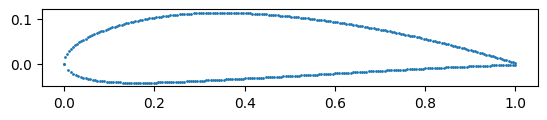

In [2]:
airfoil = af.Airfoil.NACA4("4415", n_points=200)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

alpha0 = -4 * np.pi / 180

# Wing Geometry

In [4]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)


def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)

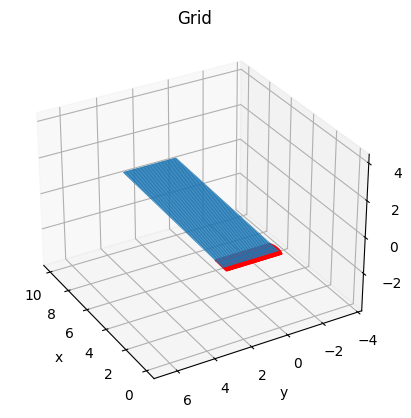

In [9]:
N = 50
M = 3
wg = Wing(
    airfoil=airfoil,
    isSymmetric=True,
    span=3,
    alpha=2,
    beta=0,
    Ni=N,
    Nj=M,
    sweepAngle=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)

## Wind

In [10]:
Umag = 20
dens = 1.2

# Symmetric Wing

In [11]:
def symm_wing(x, y, z, i, j, panel):

    Ui = pot.hshoeSL2(x, y, z, i, j, panel, 1.)
    Uii = pot.hshoeSL2(x, -y, z, i, j, panel, 1.)

    U_ind = np.array([Ui[0] + Uii[0],
                      Ui[1] - Uii[1],
                      Ui[2] + Ui[2]])
    return U_ind

In [13]:
a = np.zeros(((N-1)*(M-2), (N-1)*(M-2)))
infMat = np.zeros(((N-1)*(M-2), (N-1)*(M-2)))

RHS = np.zeros((N-1)*(M-2))
w_ind = np.zeros((N-1, 3))
L_pan = np.zeros((N-1))
D_pan = np.zeros((N-1))

for i in np.arange(0, N-1):
    RHS[i] = np.pi * (wg.alpha - alpha0) * wg.Dchord[i] * Umag
    for j in np.arange(0, N-1):
        k = 0
        U = symm_wing((wg.grid[i, 0, 0] + wg.grid[i+1, 0, 0])/2,
                      (wg.grid[i, 0, 1] + wg.grid[i+1, 0, 1])/2,
                      (wg.grid[i, 0, 2] + wg.grid[i+1, 0, 2])/2,
                      k,j, wg.grid)
        a[i, j] = np.dot(wg.nj[i], U)
        infMat[i, j] = - a[i, j] * wg.Dchord[i] * np.pi
    infMat[i, i] = infMat[i, i] + 1

Gammas = np.linalg.solve(infMat, RHS)
w_ind = np.matmul(a, Gammas)

wingArea = 0
for i in np.arange(0, N-1):
    L_pan[i] = dens * Umag * Gammas[i] * \
        (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])
    D_pan[i] = - dens * w_ind[i] * Gammas[i] * \
        (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])
    wingArea += (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1]) * wg.Dchord[i]
L_DoubleTrouble = np.sum(L_pan)
D_DoubleTrouble = np.sum(D_pan)

print(f"L:{L_DoubleTrouble}\t|\tD:{D_DoubleTrouble}")
print(f"CL:{L_DoubleTrouble/(dens*(Umag**2)*wingArea)}\t|\tCD_ind:{D_DoubleTrouble/(dens*(Umag**2)*wingArea)}")


L:200.85072292044592	|	D:11.644102426455696
CL:0.13947966869475412	|	CD_ind:0.008086182240594233


/tmp/ipykernel_424140/2929261820.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


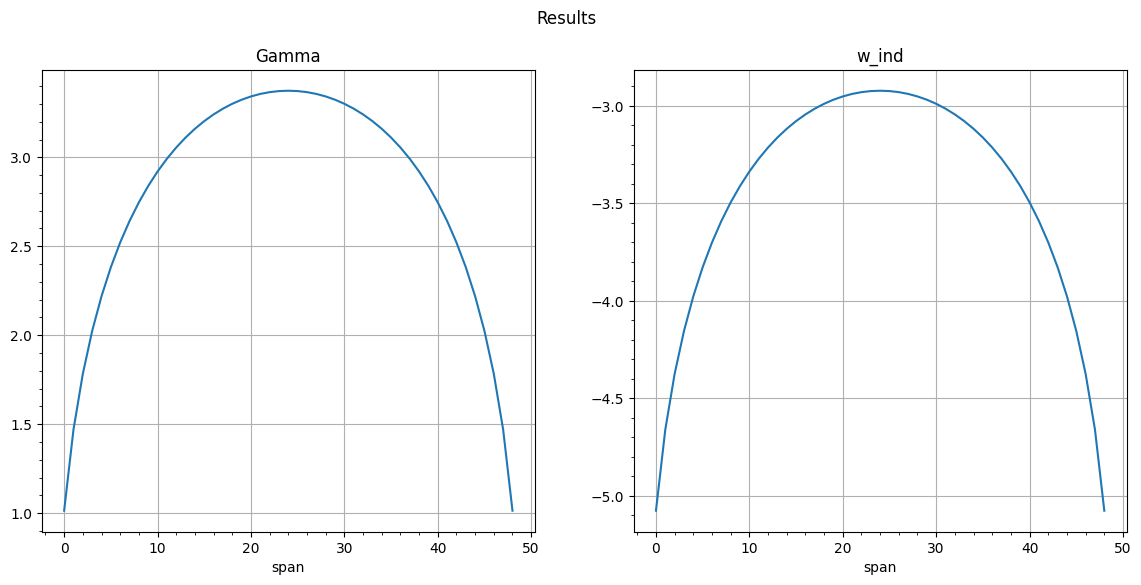

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Results')

ax1.plot(Gammas)
ax1.set_xlabel("span")
ax1.set_title("Gamma")
ax1.minorticks_on()
ax1.grid()

ax2.plot((w_ind/Umag) * 180 / np.pi)
ax2.set_xlabel("span")
ax2.set_title("w_ind")
ax2.minorticks_on()
ax2.grid()
fig.show()